In [1]:
# Import the modules
import sqlite3

import spiceypy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Establish a connection to the comet database
con = sqlite3.connect('../../databases/comets/mpc_comets.db')

# Extract information about the comet 67P
comet_67p_from_db = pd.read_sql('SELECT NAME, PERIHELION_AU, ' \
                                'SEMI_MAJOR_AXIS_AU, ' \
                                'APHELION_AU, ECCENTRICITY, ' \
                                'ARG_OF_PERIH_DEG, LONG_OF_ASC_NODE_DEG ' \
                                'FROM comets_main WHERE NAME LIKE "67P%"', con)

In [3]:
# Print the orbital elements of 67P
print(f'{comet_67p_from_db.iloc[0]}')

NAME                    67P/Churyumov-Gerasimenko
PERIHELION_AU                            1.210396
SEMI_MAJOR_AXIS_AU                       3.457563
APHELION_AU                               5.70473
ECCENTRICITY                             0.649928
ARG_OF_PERIH_DEG                          22.1553
LONG_OF_ASC_NODE_DEG                      36.3291
Name: 0, dtype: object


In [4]:
# Load SPICE kernels (meta file)
spiceypy.furnsh('kernel_meta.txt')

# Get the G*M value for the Sun
_, GM_SUN_PRE = spiceypy.bodvcd(bodyid=10, item='GM', maxn=1)
GM_SUN = GM_SUN_PRE[0]

In [5]:
# Set an initial and end time
ini_datetime = pd.Timestamp('2004-01-01')
end_datetime = pd.Timestamp('2014-01-01')

# Create a numpy array with 1000 timesteps between the initial and end time
datetime_range = np.linspace(ini_datetime.value, end_datetime.value, 1000)

# Convert the numpy arraay to a pandas date-time object
datetime_range = pd.to_datetime(datetime_range)

In [6]:
# Set an initial dataframe for the 67P computations
comet_67p_df = pd.DataFrame([])

# Set the UTC date-times
comet_67p_df.loc[:, 'UTC'] = datetime_range

# Convert the UTC date-time strings to ET
comet_67p_df.loc[:, 'ET'] = comet_67p_df['UTC'].apply(lambda x: \
                              spiceypy.utc2et(x.strftime('%Y-%m-%dT%H:%M:%S')))

# Compute the ET corresponding state vectors
comet_67p_df.loc[:, 'STATE_VEC'] = \
    comet_67p_df['ET'].apply(lambda x: spiceypy.spkgeo(targ=1000012, \
                                                       et=x, \
                                                       ref='ECLIPJ2000', \
                                                       obs=10)[0])

# Compute the state vectors corresponding orbital elements
comet_67p_df.loc[:, 'STATE_VEC_ORB_ELEM'] = \
    comet_67p_df.apply(lambda x: spiceypy.oscltx(state=x['STATE_VEC'], \
                                                 et=x['ET'], \
                                                 mu=GM_SUN), \
                       axis=1)

In [7]:
# Assign miscellaneous orbital elements as individual columns
# Set the perihelion. Convert km to AU
comet_67p_df.loc[:, 'PERIHELION_AU'] = \
    comet_67p_df['STATE_VEC_ORB_ELEM'].apply(lambda x: \
                                             spiceypy.convrt(x[0], \
                                                             inunit='km', \
                                                             outunit='AU'))

# Set the eccentricity
comet_67p_df.loc[:, 'ECCENTRICITY'] = \
    comet_67p_df['STATE_VEC_ORB_ELEM'].apply(lambda x: x[1])

# Set the inclination in degrees
comet_67p_df.loc[:, 'INCLINATION_DEG'] = \
    comet_67p_df['STATE_VEC_ORB_ELEM'].apply(lambda x: np.degrees(x[2]))

# Set the longitude of ascending node in degrees
comet_67p_df.loc[:, 'LONG_OF_ASC_NODE_DEG'] = \
    comet_67p_df['STATE_VEC_ORB_ELEM'].apply(lambda x: np.degrees(x[3]))

# Set the argument of perihelion in degrees
comet_67p_df.loc[:, 'ARG_OF_PERIH_DEG'] = \
    comet_67p_df['STATE_VEC_ORB_ELEM'].apply(lambda x: np.degrees(x[4]))

# Set the semi-major axis in AU
comet_67p_df.loc[:, 'SEMI_MAJOR_AXIS_AU'] = \
    comet_67p_df['STATE_VEC_ORB_ELEM'].apply(lambda x: \
                                             spiceypy.convrt(x[-2], \
                                                             inunit='km', \
                                                             outunit='AU'))

# Compute the aphelion, based on the semi-major axis and eccentricity
comet_67p_df.loc[:, 'APHELION_AU'] = \
    comet_67p_df.apply(lambda x: x['SEMI_MAJOR_AXIS_AU'] \
                                 * (1.0 + x['ECCENTRICITY']), \
                       axis=1)

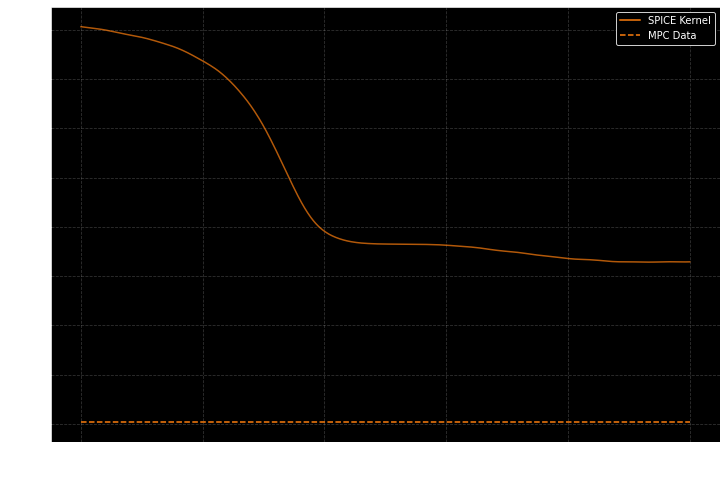

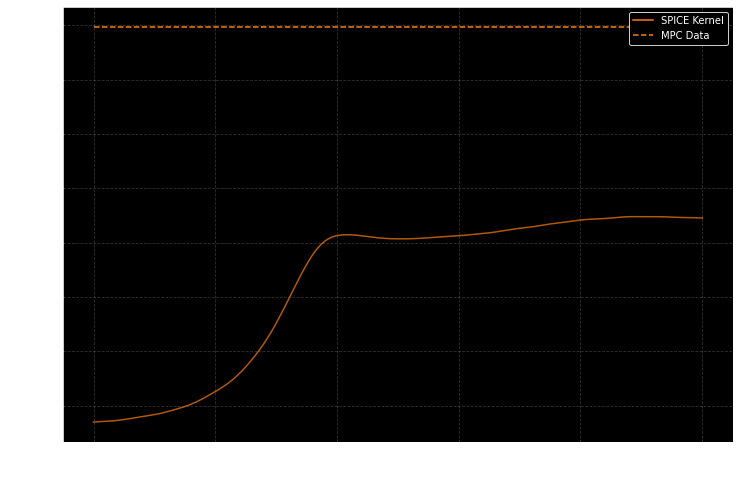

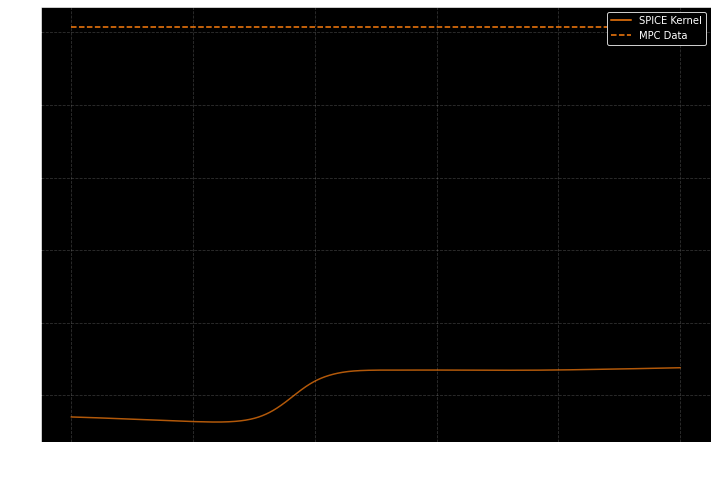

In [8]:
# Let's plot the perihelion, eccentricity and argument of perihelion

# Let's set a dark background
plt.style.use('dark_background')

# Set a default font size for better readability
plt.rcParams.update({'font.size': 14})

# We plot the data dynamically in a for loop. col_name represents the column
# name for both dataframes; ylabel_name is used to change the y label.
for col_name, ylabel_name in zip(['PERIHELION_AU', \
                                  'ECCENTRICITY', \
                                  'ARG_OF_PERIH_DEG'], \
                                 ['Perihelion in AU', \
                                  'Eccentricity', \
                                  'Arg. of. peri. in degrees']):

    # Set a figure with a certain figure size
    fig, ax = plt.subplots(figsize=(12, 8))

    # Line plot of the parameter vs. the UTC date-time from the SPICE data
    ax.plot(comet_67p_df['UTC'], \
            comet_67p_df[col_name], \
            color='tab:orange', alpha=0.7, label='SPICE Kernel')

    # As a guideline, plot the parameter data from the MPC data set as a
    # horizontal line
    ax.hlines(y=comet_67p_from_db[col_name], \
              xmin=ini_datetime, \
              xmax=end_datetime, \
              color='tab:orange', linestyles='dashed', label='MPC Data')


    # Set a grid for better readability
    ax.grid(axis='both', linestyle='dashed', alpha=0.2)

    # Set labels for the x and y axis
    ax.set_xlabel('Time in UTC')
    ax.set_ylabel(ylabel_name)

    # Now we set a legend. However, the marker opacity in the legend has the
    # same value as in the plot ...
    leg = ax.legend(fancybox=True, loc='upper right', framealpha=1)

    # ... thus, we set the markers' opacity to 1 with this small code
    for lh in leg.legend_handles:
        lh.set_alpha(1)

    # Save the plot in high quality
    plt.savefig(f'67P_{col_name}.png', dpi=300)